# Indroduction
Text Classification Algorithm are at the heart of a variety of software systems that process text data at scale. Email software uses Text Classification to determine whether incomin email is sent to the inbox or filtered into the spam folder. Discussion forum use text classification to determine whether comments should be flagged as inappropiate.

These are two example of text classification, categorizing a text document into one of the predefined set of topics. In many topic classification problem, this categorization is based primarily on keywords in the texts.

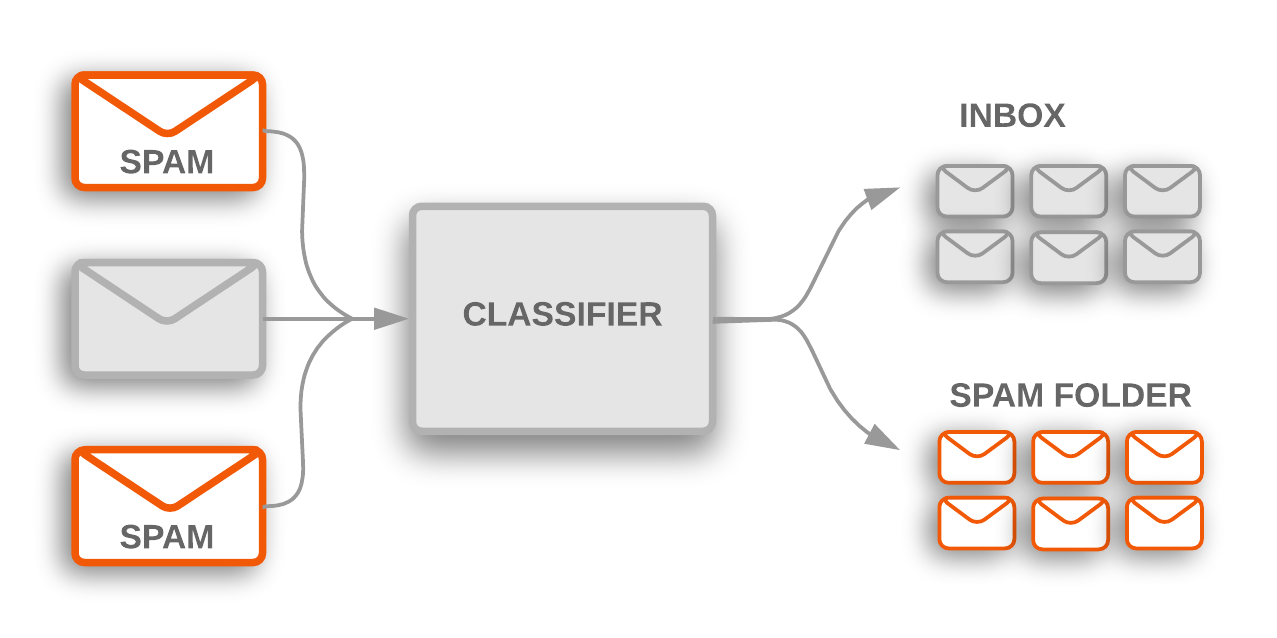

### Figure 1. Topic classification is used to flag incoming spam emails, which the filter into the spam folder.
Another type of text classification is sentiment analysis, whose goal is to identify the polarity of text content: the type of opinion it expresses. This can take the form of binary like/dislike rating, or a more granual set of options, such as star rating from 1 to 5. Example of sentiment analysis include analyzing twitter posts to determine if people liked the black panthor movie, or extrapolating the general public opinion of a new brand of nike shoes from walmart reviews.

This guide will teach you smoke key machine learning best practices for solving text classification problems.
1. The high level, end-to-end workflow for solving text classification problems using machine learning.
2. How to choose the right model for your text classification problem.
3. How to implement model of choice using TendorFlow.

## Text Classification Work Flow
 Here is a high level overview:
 * Step 1   - Gather Data
 * Step 2   - Explore your Data
 * Step 2.5 - Choose a Model
 * Step 3   - Prepare your Data
 * Step 4   - Bild, train and evaluate your model
 * Step 5   - Tune Hyperparameters
 * Step 6   - Deploy your Model
 
 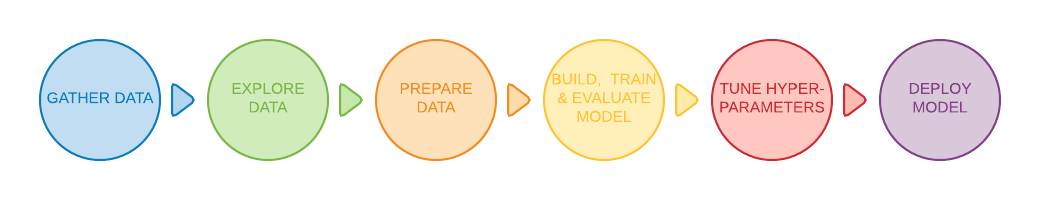
 
### Figure 2. Workflow for solving machine learning problems
 
# Step 1: Gather Data
Gathering data is the most important step in solving any supervised machine learning problem. Your text classifier can only be as good as the dataset it is built from.
If you don’t have a specific problem you want to solve and are just interested in exploring text classification in general, there are plenty of open source datasets available. You can find links to some of them in our GitHub repo. On the other hand, if you are tackling a specific problem, you will need to collect the necessary data. Many organizations provide public APIs for accessing their data—for example, the Twitter API or the NY Times API. You may be able to leverage these for the problem you are trying to solve.
Here are some important things to remember when collecting data:
If you are using a public API, understand the limitations of the API before using them. For example, some APIs set a limit on the rate at which you can make queries.
The more training examples (referred to as samples in the rest of this guide) you have, the better. This will help your model generalize better.
Make sure the number of samples for every class or topic is not overly imbalanced. That is, you should have comparable number of samples in each class.
Make sure that your samples adequately cover the space of possible inputs, not only the common cases.
Throughout this guide, we will use the Internet Movie Database (IMDb) movie reviews dataset to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

# Step 2: Explore your Data
Building and training a model is only one part of the workflow. Understanding the characteristics of your data beforehand will enable you to build a better model. This could simply mean obtaining a higher accuracy. It could also mean requiring less data for training, or fewer computational resources


# Uploading Data

In [1]:
from pathlib import Path
import os
import random
import numpy as np
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    imdb_data_path = os.path.join(data_path, 'aclImdb')
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname),encoding='utf-8') as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)    
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding='utf-8') as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)    
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    
    return((train_texts, np.array(train_labels)),
           (test_texts, np.array(test_labels)))

load_imdb_sentiment_analysis_dataset('')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'aclImdb\\train\\pos'

### Check the Data
After loading the data, it’s good practice to run some checks on it: pick a few samples and manually check if they are consistent with your expectations. For example, print a few random samples to see if the sentiment label corresponds to the sentiment of the review. Here is a review we picked at random from the IMDb dataset: “Ten minutes worth of story stretched out into the better part of two hours. When nothing of any significance had happened at the halfway point I should have left.” The expected sentiment (negative) matches the sample’s label.

Collect Key Metrics

Once you’ve verified the data, collect the following important metrics that can help characterize your text classification problem:

Number of samples: Total number of examples you have in the data.
Number of classes: Total number of topics or categories in the data.
Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a 
                             similar number of samples; in an imbalanced dataset, the number of samples in each class will vary                              widely.
Number of words per sample: Median number of words in one sample.
Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.
Distribution of sample length: Distribution showing the number of words per sample in the dataset.

   

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__  import print_function

import numpy as np
import matplotlib.pyplot as plt
from collections import counter
from sklearn.feature_extraction.text import CountVectorizer

def get_num_classes(labels):
    """ Get the number of classes
    Arguments:
    labels- list, label values.
             Thre should be atleast one sample of values in the
             range(0, num_classes-1)
    
    Returns:
      int, total number od classes.
    Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """  
    
    num_classes = max(labels+1)
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('missing smaples with label value(s)'
                         '{missing_classes}. Please make sure you have'
                         ' in the range(0, {max_class})'.format(
                          missing_classes = missing_classes, max_class = num_classes-1))
    
    if num_classes <= 1:
        raise ValueErroe('Invalid number of labels: {num_classes}.'
                         ' Please make sure their are aleast two classes'
                         'of samples'.format(num_classes=num_classes))
    return num_classes

def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
                                          
 
    # Create args required for vectorizing.
    
    kwargs = {'ngram_range':(1, 1),
              'dtype':'int32',
              'strip_accents':'unicode',
              'decode_error':'replace',
              'analyzer':'word'}
    vectorizer = CountVectorizer(**kwargs)
    
    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    
    vectorized_texts = vectorizer.fit_transform(sample_texts)
    
    # This is the list of all n-grams in the index order fromthe vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    

    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]
    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
                             zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]
    
    
    idx = np.arange(num_ngrams)
    plt.bat(idx, counts, width=0.8, color='b')
    plt.xlabel("N-grams")
    plt.ylabel("Frequencies")
    plt.title("Frequencies distribution of n-grams")
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

def plot_sample_length_distribution(sample_texts):
   
               
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()   
               
    
    

ImportError: cannot import name 'counter' from 'collections' (c:\users\monika\appdata\local\programs\python\python37\lib\collections\__init__.py)